In [1]:
library(nlme) #lmm with AR()
library(dplyr) #df manipulation

Warning message:
"package 'nlme' was built under R version 3.6.3"
Warning message:
"package 'dplyr' was built under R version 3.6.3"

Attaching package: 'dplyr'


The following object is masked from 'package:nlme':

    collapse


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
nID <- 50
nrep <- 51

# State values of desired parameters
AR_low <- 0.2
AR_med <- 0.4
AR_high <- 0.6
Ve1 <- 0.6 * (1/sqrt(1 / (1 - AR_low^2)))^2
Ve2 <- 0.6 * (1/sqrt(1 / (1 - AR_med^2)))^2
Ve3 <- 0.6 * (1/sqrt(1 / (1 - AR_high^2)))^2
Vid <- 0.4

rep2 <- 1:nrep
rep3 <- 1:nrep
rep2 <- rep2[rep2 %% 2 == 1]
rep3 <- rep3[rep3 %% 5 == 1]
Ve1; Ve2; Ve3

[1] 0.576

[1] 0.504

[1] 0.384

# As in article

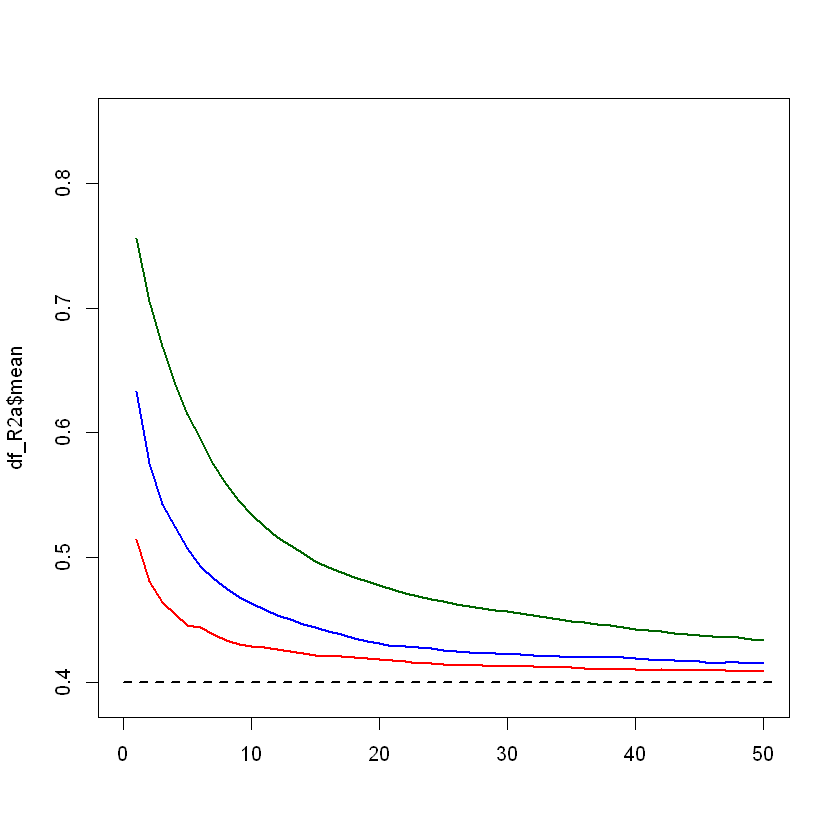

In [117]:
#set.seed(15) # make sure sampling each time is independent
#initialise the list of repeatability matrix
nbr_run = 100
#initialise the repeatability matrix
#R = list(r2a =rep(0,nrep), r4a =rep(0,nrep), r6a =rep(0,nrep))
R2a = matrix(, nrow=nrep, ncol=nbr_run)
R4a = matrix(, nrow=nrep, ncol=nbr_run)
R6a = matrix(, nrow=nrep, ncol=nbr_run)

for (r in 1:nbr_run){
    ID = rnorm(nID, 0,sqrt(Vid)) # Generate BLUPs to simulate from
    ds = data.frame(id=sort(rep(c(1:nID),nrep)), ID=sort(rep(ID,nrep)), rep=(rep(c(1:nrep),nID)))
    ds = ds[order(ds$id),]
    #dim(ds)
    #head(ds, 3)
    #summary(ds)

    #This is followed by simulating the response variable for each individual ‘i’. 
    #Each individual is simulated as a time series, with an AR1 correlation coefficient 
    #and the calculated residual standard deviation.
    #initerate over individuals
    for(i in 1:nID){
        ds$y1[ds$id == i] <- ds$ID[ds$id == i] +
        arima.sim(model=list(ar=AR_low),n=nrep, sd =sqrt(Ve1), n.start = 200)

        ds$y2[ds$id == i] <- ds$ID[ds$id == i] +
        arima.sim(model=list(ar=AR_med),n=nrep, sd =sqrt(Ve2), n.start = 200)

        ds$y3[ds$id == i] <- ds$ID[ds$id == i] +
        arima.sim(model=list(ar=AR_high),n=nrep, sd =sqrt(Ve3), n.start = 200)}
    #dim(ds)
    #head(ds, 3)
    #summary(ds)
    
    for(k in 2:nrep){
        mod <-lme(y1 ~ 1, random = ~1|id,data =subset(ds, rep <= k))
        mod2<-lme(y2 ~ 1, random = ~1|id,data =subset(ds, rep <= k))
        mod3<-lme(y3 ~ 1, random = ~1|id,data =subset(ds, rep <= k))

        R2a[k-1,r] <-as.numeric(VarCorr(mod)[1]) /(as.numeric(VarCorr(mod)[1]) +as.numeric(VarCorr(mod)[2]))
        R4a[k-1,r] <-as.numeric(VarCorr(mod2)[1]) /(as.numeric(VarCorr(mod2)[1])+as.numeric(VarCorr(mod2)[2]))
        R6a[k-1,r] <-as.numeric(VarCorr(mod3)[1]) /(as.numeric(VarCorr(mod3)[1])+as.numeric(VarCorr(mod3)[2]))
    }
    #plot(R$r2a[2:nrep], ylab ='Repeatability', xlab ='Experiment duration')
}

####################
colnames(R2a) <- as.character(seq(1, nbr_run, length.out=nbr_run))
df_R2a <- as.data.frame(R2a)
df_R2a$ROWNAME <- rownames(R2a)
df_R2a <- df_R2a %>% rowwise() %>%
  mutate(mean = mean(c_across(as.character(seq(1, nbr_run, length.out=nbr_run)))))

####################
colnames(R4a) <- as.character(seq(1, nbr_run, length.out=nbr_run))
df_R4a <- as.data.frame(R4a)
df_R4a$ROWNAME <- rownames(R4a)
df_R4a <- df_R4a %>% rowwise() %>%
  mutate(mean = mean(c_across(as.character(seq(1, nbr_run, length.out=nbr_run)))))

####################
colnames(R6a) <- as.character(seq(1, nbr_run, length.out=nbr_run))
df_R6a <- as.data.frame(R6a)
df_R6a$ROWNAME <- rownames(R6a)
df_R6a <- df_R6a %>% rowwise() %>%
  mutate(mean = mean(c_across(as.character(seq(1, nbr_run, length.out=nbr_run)))))

plot(df_R2a$mean, xlab ='', type ='l', ylim =c(0.39,0.8), xlim =c(0,50), col = "red", lwd = 2)
lines(df_R4a$mean, type ='l', col ='blue', lwd = 2)
lines(df_R6a$mean, type ='l', col ='dark green', lwd = 2)
lines(x =c(0, nrep), y =c(0.4,0.4), col='black', lty=2, lwd = 2)

# With AR when computing R

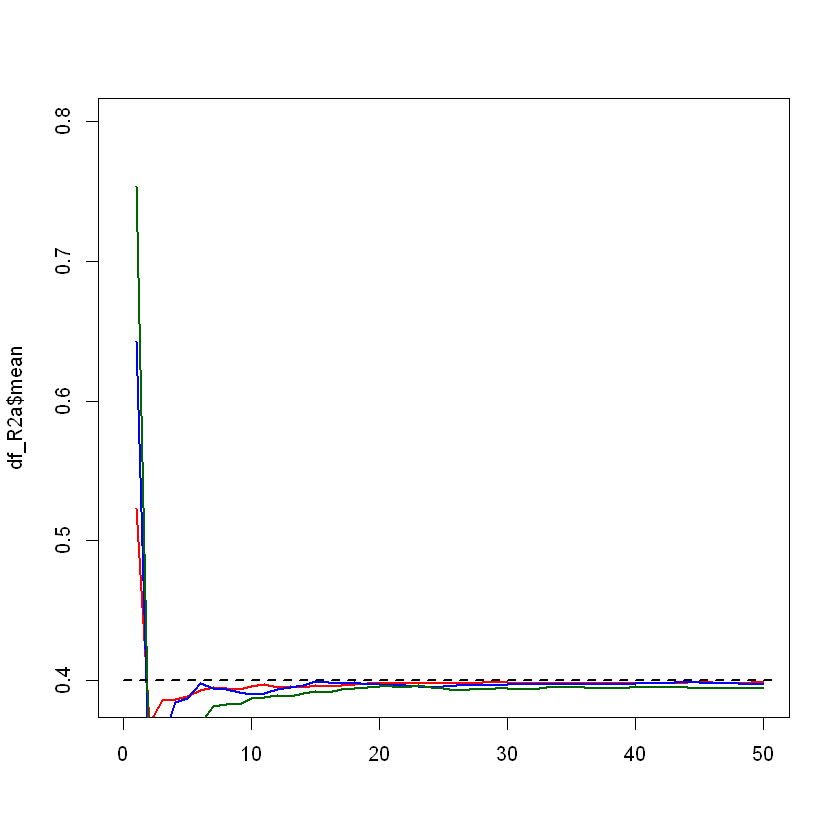

In [3]:
#set.seed(15) # make sure sampling each time is independent
#initialise the list of repeatability matrix
nbr_run = 100
#initialise the repeatability matrix
#R = list(r2a =rep(0,nrep), r4a =rep(0,nrep), r6a =rep(0,nrep))
R2a = matrix(, nrow=nrep, ncol=nbr_run)
R4a = matrix(, nrow=nrep, ncol=nbr_run)
R6a = matrix(, nrow=nrep, ncol=nbr_run)

for (r in 1:nbr_run){
    ID = rnorm(nID, 0,sqrt(Vid)) # Generate BLUPs to simulate from
    ds = data.frame(id=sort(rep(c(1:nID),nrep)), ID=sort(rep(ID,nrep)), rep=(rep(c(1:nrep),nID)))
    ds = ds[order(ds$id),]
    
    #This is followed by simulating the response variable for each individual ‘i’. 
    #Each individual is simulated as a time series, with an AR1 correlation coefficient 
    #and the calculated residual standard deviation.
    for(i in 1:nID){
        ds$y1[ds$id == i] <- ds$ID[ds$id == i] +
        arima.sim(model=list(ar=AR_low),n=nrep, sd =sqrt(Ve1), n.start = 200)

        ds$y2[ds$id == i] <- ds$ID[ds$id == i] +
        arima.sim(model=list(ar=AR_med),n=nrep, sd =sqrt(Ve2), n.start = 200)

        ds$y3[ds$id == i] <- ds$ID[ds$id == i] +
        arima.sim(model=list(ar=AR_high),n=nrep, sd =sqrt(Ve3), n.start = 200)}
    
    for(k in 2:nrep){
        mod <-lme(y1 ~ 1, random = ~1|id,data =subset(ds, rep <= k))
        mod = update(mod, corr = corARMA(form = ~rep, p = 1, q = 0)) #p=1, q=0: AR1

        mod2<-lme(y2 ~ 1, random = ~1|id,data =subset(ds, rep <= k))
        mod2 = update(mod2, corr = corARMA(form = ~rep, p = 1, q = 0)) #p=1, q=0: AR1

        mod3<-lme(y3 ~ 1, random = ~1|id,data =subset(ds, rep <= k))
        mod3 = update(mod3, corr = corARMA(form = ~rep, p = 1, q = 0)) #p=1, q=0: AR1

        R2a[k-1,r] <-as.numeric(VarCorr(mod)[1]) /(as.numeric(VarCorr(mod)[1]) +as.numeric(VarCorr(mod)[2]))
        R4a[k-1,r] <-as.numeric(VarCorr(mod2)[1]) /(as.numeric(VarCorr(mod2)[1])+as.numeric(VarCorr(mod2)[2]))
        R6a[k-1,r] <-as.numeric(VarCorr(mod3)[1]) /(as.numeric(VarCorr(mod3)[1])+as.numeric(VarCorr(mod3)[2]))
    }
}

####################
colnames(R2a) <- as.character(seq(1, nbr_run, length.out=nbr_run))
df_R2a <- as.data.frame(R2a)
df_R2a$ROWNAME <- rownames(R2a)
df_R2a <- df_R2a %>% rowwise() %>%
  mutate(mean = mean(c_across(as.character(seq(1, nbr_run, length.out=nbr_run)))))

####################
colnames(R4a) <- as.character(seq(1, nbr_run, length.out=nbr_run))
df_R4a <- as.data.frame(R4a)
df_R4a$ROWNAME <- rownames(R4a)
df_R4a <- df_R4a %>% rowwise() %>%
  mutate(mean = mean(c_across(as.character(seq(1, nbr_run, length.out=nbr_run)))))

####################
colnames(R6a) <- as.character(seq(1, nbr_run, length.out=nbr_run))
df_R6a <- as.data.frame(R6a)
df_R6a$ROWNAME <- rownames(R6a)
df_R6a <- df_R6a %>% rowwise() %>%
  mutate(mean = mean(c_across(as.character(seq(1, nbr_run, length.out=nbr_run)))))

plot(df_R2a$mean, xlab ='', type ='l', ylim =c(0.29,0.8), xlim =c(0,50), col = "red", lwd = 2)
lines(df_R4a$mean, type ='l', col ='blue', lwd = 2)
lines(df_R6a$mean, type ='l', col ='dark green', lwd = 2)
lines(x =c(0, nrep), y =c(0.4,0.4), col='black', lty=2, lwd = 2)

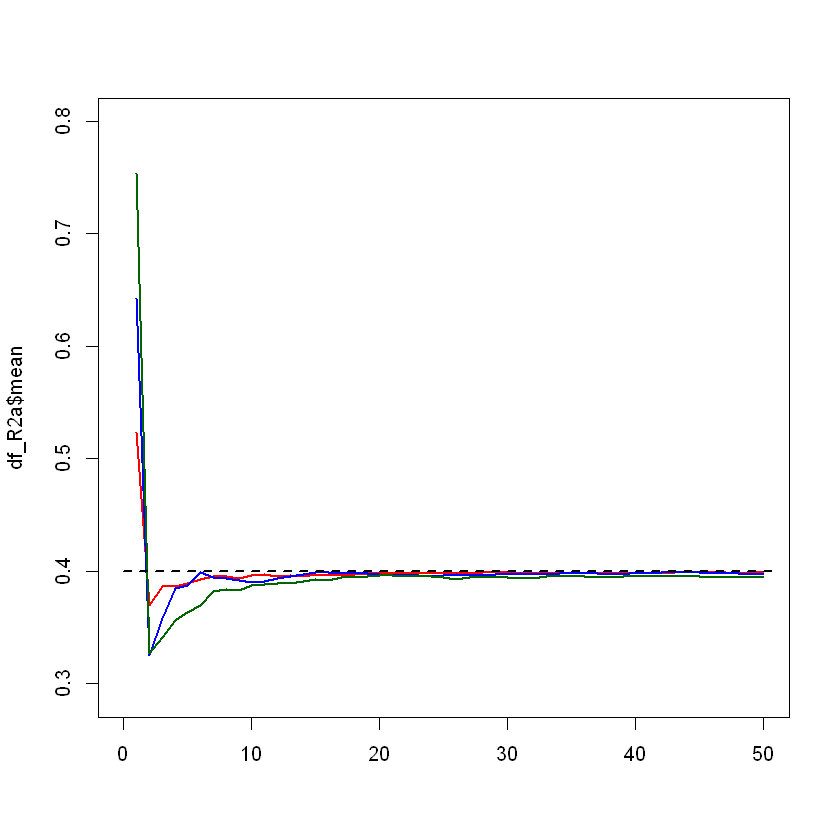

In [6]:
plot(df_R2a$mean, xlab ='', type ='l', ylim =c(0.29,0.8), xlim =c(0,50), col = "red", lwd = 2)
lines(df_R4a$mean, type ='l', col ='blue', lwd = 2)
lines(df_R6a$mean, type ='l', col ='dark green', lwd = 2)
lines(x =c(0, nrep), y =c(0.4,0.4), col='black', lty=2, lwd = 2)

# Add trend

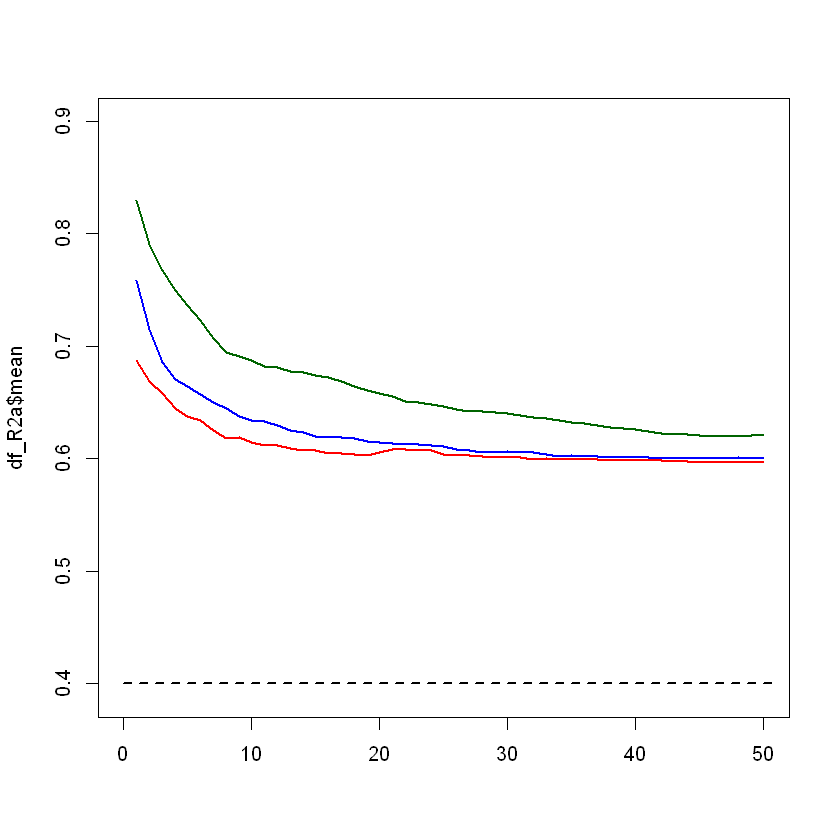

In [22]:
#WITH trend
Vidslope = 0.1
Vid = 0.4
#set.seed(15) # make sure sampling each time is independent
#initialise the list of repeatability matrix
nbr_run = 10
#initialise the repeatability matrix
R2a = matrix(, nrow=nrep, ncol=nbr_run)
R4a = matrix(, nrow=nrep, ncol=nbr_run)
R6a = matrix(, nrow=nrep, ncol=nbr_run)

for (r in 1:nbr_run){
    ID = rnorm(nID, 0,sqrt(Vid)) # Generate BLUPs INTERCEPTS to simulate from
    IDS = rnorm(nID, 0,sqrt(Vidslope)) # Generate BLUPs SLOPE to simulate from
    ds = data.frame(id=sort(rep(c(1:nID),nrep)), ID=sort(rep(ID,nrep)), IDS_=sort(rep(IDS,nrep)), rep=(rep(c(1:nrep),nID)))
    ds %>% mutate(IDS = IDS_ * rep)
    
    #This is followed by simulating the response variable for each individual ‘i’. 
    #Each individual is simulated as a time series, with an AR1 correlation coefficient 
    #and the calculated residual standard deviation.
    for(i in 1:nID){
        ds$y1[ds$id == i] <- ds$ID[ds$id == i] + 
        arima.sim(model=list(ar=AR_low),n=nrep, sd=sqrt(Ve1)) + ds$IDS[ds$id == i]

        ds$y2[ds$id == i] <- ds$ID[ds$id == i] + 
        arima.sim(model=list(ar=AR_med),n=nrep, sd=sqrt(Ve2)) + ds$IDS[ds$id == i]

        ds$y3[ds$id == i] <- ds$ID[ds$id == i] +
        arima.sim(model=list(ar=AR_high),n=nrep, sd=sqrt(Ve3))+ ds$IDS[ds$id == i]}
    
    for(k in 2:nrep){
        mod <-lme(y1 ~ 1, random = ~1|id, data=subset(ds, rep <= k))
        mod2<-lme(y2 ~ 1, random = ~1|id, data=subset(ds, rep <= k))
        mod3<-lme(y3 ~ 1, random = ~1|id, data=subset(ds, rep <= k))

        R2a[k-1,r] <-as.numeric(VarCorr(mod)[1]) /(as.numeric(VarCorr(mod)[1]) +as.numeric(VarCorr(mod)[2]))
        R4a[k-1,r] <-as.numeric(VarCorr(mod2)[1]) /(as.numeric(VarCorr(mod2)[1])+as.numeric(VarCorr(mod2)[2]))
        R6a[k-1,r] <-as.numeric(VarCorr(mod3)[1]) /(as.numeric(VarCorr(mod3)[1])+as.numeric(VarCorr(mod3)[2]))
    }
}

####################
colnames(R2a) <- as.character(seq(1, nbr_run, length.out=nbr_run))
df_R2a <- as.data.frame(R2a)
df_R2a$ROWNAME <- rownames(R2a)
df_R2a <- df_R2a %>% rowwise() %>%
  mutate(mean = mean(c_across(as.character(seq(1, nbr_run, length.out=nbr_run)))))

####################
colnames(R4a) <- as.character(seq(1, nbr_run, length.out=nbr_run))
df_R4a <- as.data.frame(R4a)
df_R4a$ROWNAME <- rownames(R4a)
df_R4a <- df_R4a %>% rowwise() %>%
  mutate(mean = mean(c_across(as.character(seq(1, nbr_run, length.out=nbr_run)))))

####################
colnames(R6a) <- as.character(seq(1, nbr_run, length.out=nbr_run))
df_R6a <- as.data.frame(R6a)
df_R6a$ROWNAME <- rownames(R6a)
df_R6a <- df_R6a %>% rowwise() %>%
  mutate(mean = mean(c_across(as.character(seq(1, nbr_run, length.out=nbr_run)))))

plot(df_R2a$mean, xlab ='', type ='l', ylim =c(0.39,0.9), xlim =c(0,50), col = "red", lwd = 2)
lines(df_R4a$mean, type ='l', col ='blue', lwd = 2)
lines(df_R6a$mean, type ='l', col ='dark green', lwd = 2)
lines(x =c(0, nrep), y =c(0.4,0.4), col='black', lty=2, lwd = 2)

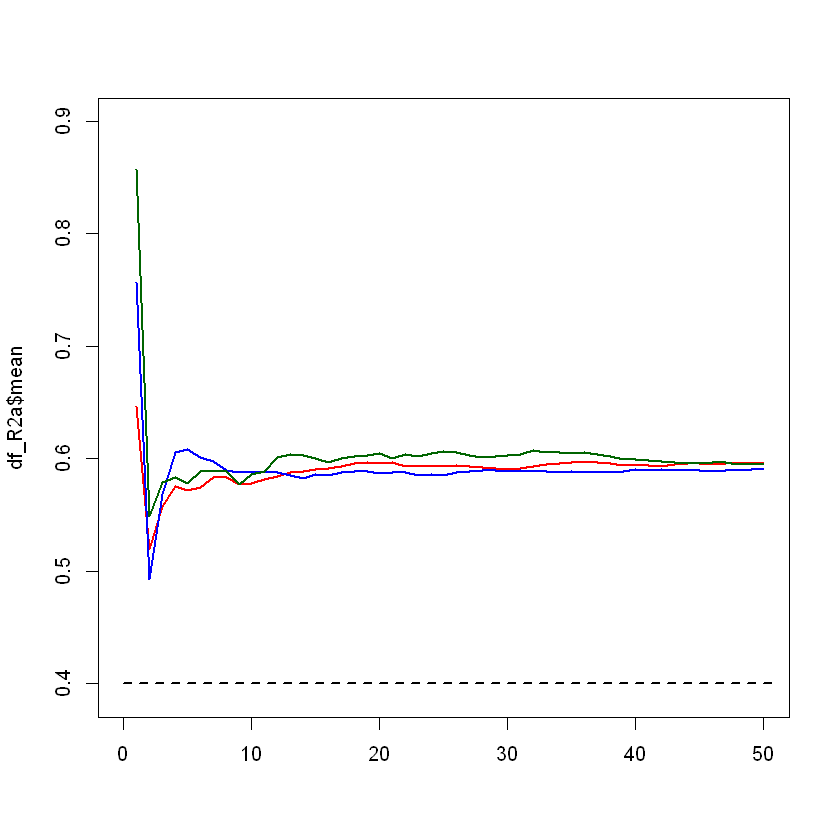

In [20]:
#WITH trend WITH AR
Vidslope = 0.1
Vid = 0.4

#set.seed(15) # make sure sampling each time is independent
#initialise the list of repeatability matrix
nbr_run = 10
#initialise the repeatability matrix
#R = list(r2a =rep(0,nrep), r4a =rep(0,nrep), r6a =rep(0,nrep))
R2a = matrix(, nrow=nrep, ncol=nbr_run)
R4a = matrix(, nrow=nrep, ncol=nbr_run)
R6a = matrix(, nrow=nrep, ncol=nbr_run)

for (r in 1:nbr_run){
    ID = rnorm(nID, 0,sqrt(Vid)) # Generate BLUPs INTERCEPTS to simulate from
    IDS = rnorm(nID, 0,sqrt(Vidslope)) # Generate BLUPs SLOPE to simulate from
    ds = data.frame(id=sort(rep(c(1:nID),nrep)), ID=sort(rep(ID,nrep)), IDS_=sort(rep(IDS,nrep)), rep=(rep(c(1:nrep),nID)))
    ds %>% mutate(IDS = IDS_ * rep)
    
    #This is followed by simulating the response variable for each individual ‘i’. 
    #Each individual is simulated as a time series, with an AR1 correlation coefficient 
    #and the calculated residual standard deviation.
    for(i in 1:nID){
        ds$y1[ds$id == i] <- ds$ID[ds$id == i] + 
        arima.sim(model=list(ar=AR_low),n=nrep, sd=sqrt(Ve1), n.start=200) + ds$IDS[ds$id == i]

        ds$y2[ds$id == i] <- ds$ID[ds$id == i] + 
        arima.sim(model=list(ar=AR_med),n=nrep, sd=sqrt(Ve2), n.start=200) + ds$IDS[ds$id == i]

        ds$y3[ds$id == i] <- ds$ID[ds$id == i] +
        arima.sim(model=list(ar=AR_high),n=nrep, sd=sqrt(Ve3), n.start=200)+ ds$IDS[ds$id == i]}
    
    for(k in 2:nrep){
        mod <-lme(y1 ~ 1, random = ~1|id,data =subset(ds, rep <= k))
        mod = update(mod, corr = corARMA(form = ~rep, p = 1, q = 0)) #p=1, q=0: AR1

        mod2<-lme(y2 ~ 1, random = ~1|id,data =subset(ds, rep <= k))
        mod2 = update(mod2, corr = corARMA(form = ~rep, p = 1, q = 0)) #p=1, q=0: AR1

        mod3<-lme(y3 ~ 1, random = ~1|id,data =subset(ds, rep <= k))
        mod3 = update(mod3, corr = corARMA(form = ~rep, p = 1, q = 0)) #p=1, q=0: AR1

        R2a[k-1,r] <-as.numeric(VarCorr(mod)[1]) /(as.numeric(VarCorr(mod)[1]) +as.numeric(VarCorr(mod)[2]))
        R4a[k-1,r] <-as.numeric(VarCorr(mod2)[1]) /(as.numeric(VarCorr(mod2)[1])+as.numeric(VarCorr(mod2)[2]))
        R6a[k-1,r] <-as.numeric(VarCorr(mod3)[1]) /(as.numeric(VarCorr(mod3)[1])+as.numeric(VarCorr(mod3)[2]))
    }
}

####################
colnames(R2a) <- as.character(seq(1, nbr_run, length.out=nbr_run))
df_R2a <- as.data.frame(R2a)
df_R2a$ROWNAME <- rownames(R2a)
df_R2a <- df_R2a %>% rowwise() %>%
  mutate(mean = mean(c_across(as.character(seq(1, nbr_run, length.out=nbr_run)))))

####################
colnames(R4a) <- as.character(seq(1, nbr_run, length.out=nbr_run))
df_R4a <- as.data.frame(R4a)
df_R4a$ROWNAME <- rownames(R4a)
df_R4a <- df_R4a %>% rowwise() %>%
  mutate(mean = mean(c_across(as.character(seq(1, nbr_run, length.out=nbr_run)))))

####################
colnames(R6a) <- as.character(seq(1, nbr_run, length.out=nbr_run))
df_R6a <- as.data.frame(R6a)
df_R6a$ROWNAME <- rownames(R6a)
df_R6a <- df_R6a %>% rowwise() %>%
  mutate(mean = mean(c_across(as.character(seq(1, nbr_run, length.out=nbr_run)))))

plot(df_R2a$mean, xlab ='', type ='l', ylim =c(0.39,0.9), xlim =c(0,50), col = "red", lwd = 2)
lines(df_R4a$mean, type ='l', col ='blue', lwd = 2)
lines(df_R6a$mean, type ='l', col ='dark green', lwd = 2)
lines(x =c(0, nrep), y =c(0.4,0.4), col='black', lty=2, lwd = 2)